# Mowing Like a Salesperson Travels

In [1]:
import gurobi as g
import numpy as np

These classes are used for creating the map of a yard. T is for a standard tile and B is for a "blocked" tile. Blocked tiles are for areas in a yard one can't mow like trees, bushes, houses, etc.

I is used as a sort of identity service. It generates unique ids when asked. The tiles make use of this to id themselves.

In [2]:
class I:
    def __init__(self):
        self._counter = -1
    def next(self):
        self._counter += 1
        return self._counter

class T:
    def __init__(self, incrementor):
        self._connected_tiles = []
        self._id = incrementor.next()
    def connects_to(self, to_tile):
        self._connected_tiles.append(to_tile)
    def get_both_directed_edges(self):
        return [(self._id, to_tile._id) for to_tile in self._connected_tiles]
    def is_blocked(self):
        return False
class B:
    def __init__(self, incrementor):
        self._id = incrementor.next()
    def connects_to(self, to_tile):
        pass
    def get_both_directed_edges(self):
        return []
    def is_blocked(self):
        return True

These are scenarios I created to play with this program. These can be used further down the notebook.

In [3]:
def generate_house_tiles():
    i = I()
    # Create tiles for my yard as a grid
    tiles = []
    # Map grid locations to an array
    locations = []
    for row_index in range(44):
        row = []
        for column_index in range(26):
            if 0 <= row_index and row_index <= 5 and \
               0 <= column_index and column_index <= 7:
                row.append(B(i))
            elif 6 <= row_index and row_index <= 10 and \
                 0 <= column_index and column_index <= 5:
                row.append(B(i))
            elif 0 <= row_index and row_index <= 2 and \
                 19 <= column_index and column_index <= 25:
                row.append(B(i))
            elif 3 <= row_index and row_index <= 4 and \
                 20 <= column_index and column_index <= 25:
                row.append(B(i))
            elif 5 <= row_index and row_index <= 5 and \
                 23 <= column_index and column_index <= 25:
                row.append(B(i))
            elif 6 <= row_index and row_index <= 7 and \
                 24 <= column_index and column_index <= 25:
                row.append(B(i))
            elif 8 <= row_index and row_index <= 9 and \
                 25 <= column_index and column_index <= 25:
                row.append(B(i))
            elif 8 <= row_index and row_index <= 10 and \
                 10 <= column_index and column_index <= 12:
                row.append(B(i))
            elif 16 <= row_index and row_index <= 17 and \
                 1 <= column_index and column_index <= 2:
                row.append(B(i))
            elif 13 <= row_index and row_index <= 15 and \
                 6 <= column_index and column_index <= 16:
                row.append(B(i))
            elif 16 <= row_index and row_index <= 17 and \
                 6 <= column_index and column_index <= 23:
                row.append(B(i))
            elif 18 <= row_index and row_index <= 23 and \
                 5 <= column_index and column_index <= 23:
                row.append(B(i))
            elif 24 <= row_index and row_index <= 31 and \
                 5 <= column_index and column_index <= 25:
                row.append(B(i))
            elif 32 <= row_index and row_index <= 43 and \
                 21 <= column_index and column_index <= 25:
                row.append(B(i))
            elif 34 <= row_index and row_index <= 35 and \
                 17 <= column_index and column_index <= 18:
                row.append(B(i))
            elif 41 <= row_index and row_index <= 42 and \
                 5 <= column_index and column_index <= 6:
                row.append(B(i))
            elif 41 <= row_index and row_index <= 42 and \
                 9 <= column_index and column_index <= 10:
                row.append(B(i))
            elif 41 <= row_index and row_index <= 42 and \
                 13 <= column_index and column_index <= 14:
                row.append(B(i))
            elif 41 <= row_index and row_index <= 42 and \
                 17 <= column_index and column_index <= 18:
                row.append(B(i))
            else:
                row.append(T(i))
            locations.append((column_index, row_index))
        tiles.append(row)

    # Tiles mapped onto linear list
    flat_tiles = [x for row in tiles for x in row] #AKA tile_list
    return tiles, locations, flat_tiles

def generate_demo_tiles():
    i = I()
    # Create tiles for my yard as a grid
    tiles = []
    # Map grid locations to an array
    locations = []
    for row_index in range(15):
        row = []
        for column_index in range(15):
            if 4 <= row_index and row_index <= 8 and \
               2 <= column_index and column_index <= 4:
                row.append(B(i))
            elif 5 <= row_index and row_index <= 6 and \
                 5 <= column_index and column_index <= 9:
                row.append(B(i))
            elif 2 <= row_index and row_index <= 2 and \
                 6 <= column_index and column_index <= 7:
                row.append(B(i))
            elif 7 <= row_index and row_index <= 8 and \
                 8 <= column_index and column_index <= 9:
                row.append(B(i))
            else:
                row.append(T(i))
            locations.append((column_index, row_index))
        tiles.append(row)

    # Tiles mapped onto linear list
    flat_tiles = [x for row in tiles for x in row] #AKA tile_list
    return tiles, locations, flat_tiles

These functions do the hard stuff. They interpret the tile layout and create a set of edges and turns for the unblocked locations.

In [4]:
def enumerate_edge_turns(edges):
    edge_turns = set()
    for left_edge_indexes in edges:
        left_edge = tuple(locations[x] for x in left_edge_indexes)
        for right_edge_indexes in [x for x in edges if x != left_edge_indexes and left_edge_indexes[1] == x[0]]:
            right_edge = tuple(locations[x] for x in right_edge_indexes)
            if is_turn(left_edge, right_edge):
                edge_turns.add(((locations.index(left_edge[0]), locations.index(left_edge[1])), (locations.index(right_edge[0]), locations.index(right_edge[1]))))
    return edge_turns

def is_turn(edge1, edge2):
    assert edge1[1] == edge2[0], 'Edge1 doesn\'t connect to edge2! {0}'.format(edge1,edge2)
    x, y = list(zip(*[edge1[0],edge1[1],edge2[1]]))
    return not (x[0] == x[1] == x[2]) and not (y[0] == y[1] == y[2])

def generate_edges_for(tiles):
    for row_index in range(len(tiles)):
        for col_index in range(len(tiles[0])):
            from_tile = tiles[row_index][col_index]
            if from_tile.is_blocked():
                continue
            for row_offset in [-1,0,1]:
                for col_offset in [-1,0,1]:
                    offset_row_index = row_index + row_offset
                    offset_col_index = col_index + col_offset

                    if offset_row_index < 0 or offset_row_index > len(tiles)-1:
                        continue
                    if offset_col_index < 0 or offset_col_index > len(tiles[0])-1:
                        continue
                    if row_offset == 0 and col_offset == 0:
                        continue
                    if np.abs(row_offset) + np.abs(col_offset) == 2:
                        continue
                    to_tile = tiles[offset_row_index][offset_col_index]
                    if not to_tile.is_blocked():
                        from_tile.connects_to(to_tile)

    edges = [from_tile.get_both_directed_edges() for rows in tiles for from_tile in rows]
    edges = [pair for edge_list in edges for pair in edge_list]
    edge_turns = enumerate_edge_turns(edges)
    return edges, edge_turns

This code can evaluate a proposed solution and find cycles that are added as constraints.

In [5]:
def _find_cycles(solution_edges):
    cycles = []
    shortest_cycle = None
    while len(solution_edges) > 0:
        cycle=[]
        edge = solution_edges[0]
        first_node = edge[0]
        next_node = first_node
        nodes_to_remove = set()
        while True:
            next_node_index = [from_node for from_node, to_node in solution_edges].index(next_node)
            next_edge = solution_edges[next_node_index]
            next_node = next_edge[1]
            cycle.append(tuple([element for tuple_ in next_edge for element in tuple_]))
            nodes_to_remove.add(next_node_index)
            if next_node == first_node:
                print('Cycle length: ', len(cycle))
                break
        solution_edges = [x for i, x in enumerate(solution_edges) if i not in nodes_to_remove]
        cycles.append(cycle)
        if shortest_cycle is None or len(cycle) < len(shortest_cycle):
            shortest_cycle = cycle
    return shortest_cycle, len(cycles), cycles

# This method just enables debugging.
def find_cycles(location_edges):
    # We round the solution because floating point error is REAL!!
    solution_edges = [(locations[xy1], locations[xy2]) for xy1, xy2 in location_edges if round(location_edges[xy1, xy2].X) == 1]
    print('About to find cycles!')
    return _find_cycles(solution_edges)

def to_loc(edge):
    location_index_1 = locations.index((edge[0], edge[1]))
    location_index_2 = locations.index((edge[2], edge[3]))
    return (location_index_1, location_index_2)

This code is used for displaying the map and the solutions. Basically just works by plotting a line segment for every activated edge. Turns aren't necessary since the edges themselves imply turns.

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_tsp_solution(flat_tiles, location_edges=[], row_count=44, col_count=26, solution_exists=True):
    plt.figure(figsize=(col_count/3,row_count/3))
    plt.suptitle('TSP Solution to Mowing Lawn ({0} units x {1} units)'.format(col_count, row_count))
    plt.title('Red things are blocking objects')
    for column_index in range(col_count+1):
        plt.plot([-0.5+column_index, -0.5+column_index], [0-0.5, row_count+0.5-1], color='g', linestyle=':', linewidth=1);
    for row_index in range(row_count+1):
        plt.plot([0-0.5, (col_count-1)+0.5], [-0.5+row_index, -0.5+row_index], color='g', linestyle=':', linewidth=1);
    
    # If we don't have edges to plot don't try so 
    # we can still just plot the tiles without paths
    if solution_exists:
        for edge in location_edges:
            if round(location_edges[edge].X) == 1:
                xy1, xy2 = edge
                y1 = locations[xy1][1]
                x1 = locations[xy1][0]

                y2 = locations[xy2][1]
                x2 = locations[xy2][0]

                #print((x1, y1), (x2,y2))
                plt.plot([x1, x2], [y1, y2], color='k', linestyle='-', linewidth=2);
    
    # Plot blocked points
    for index, tile in enumerate(flat_tiles):
        if tile.is_blocked():
            x,y = locations[index]
            plt.scatter(x,y,c='r',marker='s',s=160);
    plt.show()

# The Mathematical Model


Variables:

$ L = (x,y)\ locations\ of\ all\ tiles$

$ E = (l_1, l_2) \in L $

$ T = (e_1, e_2)\ where\ e_1,e_2 \in E\ and\ F_T(e_1, e_2)$

$F_T(e_1, e_2) = \begin{cases} 
  1 & if\ edges\ form\ a\ turn\\
  0 & otherwise
\end{cases}$

$F_A(l_1, l_2) = \begin{cases} 
  1 & if\ locations\ are\ adjacent\\
  0 & otherwise
\end{cases}$

$x^T_{ij} = \begin{cases} 
  1 & if\ turn\ is\ used\\
  0 & otherwise
\end{cases}
where\ (i,j) \in T
$

$x^E_{ij} = \begin{cases} 
  1 & if\ edge\ is\ used\\
  0 & otherwise
\end{cases} where (i,j) \in L $

$ \sum_{i \in L} x^E_{ij} = F_A(i,j),\ \forall\ j \in L$ Each location is entered via exactly one edge

$ \sum_{j \in L} x^E_{ij} = F_A(i,j),\ \forall\ i \in L $ Each location is exited via exactly one edge

$ x^E_{ij} + x^E_{ji} <= 1,\ \forall\ i,j \in L $ A location can't loop to itself.

$-1 + x^E_i + x^E_j <= 2x^T_{ij} <= x^E_i + x^E_j\ \forall i,j \in T $

# The Coded Model

The top of the picture is the front of my house.


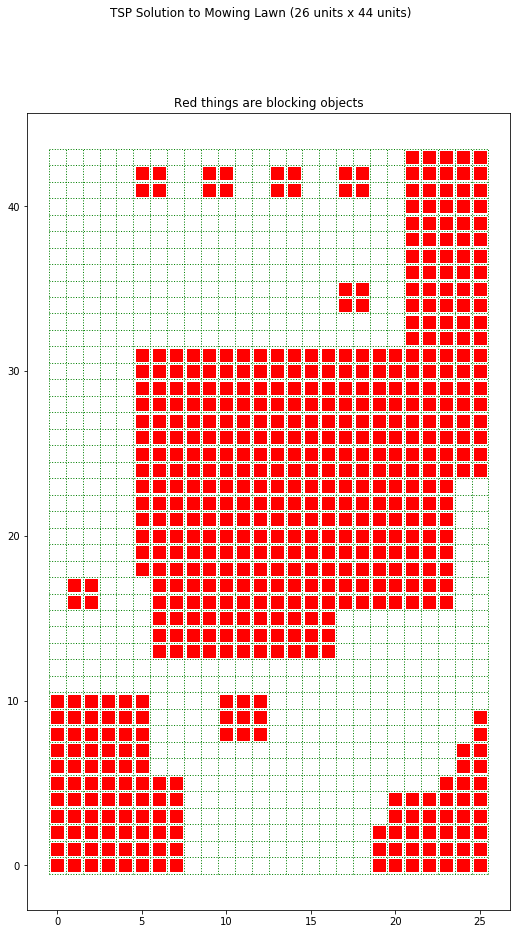

In [7]:
# For generating tiles to optimize mowing my personal yard
tiles, locations, flat_tiles = generate_house_tiles()
# This one generates a fairly solveable problem for testing.
#tiles, locations, flat_tiles = generate_demo_tiles()

# Create what I'll use for my variables
edges, edge_turns = generate_edges_for(tiles)

# Let's see what our scenario looks like without a path
print('The top of the picture is the front of my house.')
plot_tsp_solution(flat_tiles, solution_exists=False)

Create the model and define the variables we'll use. Here we create variables for every valid edge and every possible turn from each of those edges.

In [8]:
# The actual model definition
m = g.Model('tsp')
location_edges  = m.addVars(edges,  name="location_edges",  vtype=g.GRB.BINARY)
location_edge_turns  = m.addVars(edge_turns,  name="location_edge_turns",  vtype=g.GRB.BINARY)

Academic license - for non-commercial use only


For every location that isn't "blocked" (blocked meaning it has a red square in the picture above) constrain the solution such that exactly one edge leads into the location and one leads out from it.

In [9]:
for location in range(len(tiles)*len(tiles[0])):
    if not flat_tiles[location].is_blocked():
        m.addConstr(location_edges.sum(location, '*') == 1)
        m.addConstr(location_edges.sum('*', location) == 1)

Make sure no location has an edge that leads to itself.

In [10]:
for edge in location_edges:
    m.addConstr(location_edges[edge] + location_edges[(edge[1], edge[0])] <= 1)

Next add the constraints that will set the turn variables enabling us to count how many turns are made.

In [11]:
for edge_turn in edge_turns:
    # These two constraints work to fix the turn variables
    # And keep them in sync with the edges
    # -1/2 + 1/2 * (edge_1 + edge_2) <= turn_12
    # turn_12 <= 1/2 * (edge_1 + edge_2)
    m.addConstr(-1 + location_edges[edge_turn[0]] + location_edges[edge_turn[1]] <= 2*location_edge_turns[edge_turn[0], edge_turn[1]])
    m.addConstr(2*location_edge_turns[edge_turn[0], edge_turn[1]] <= location_edges[edge_turn[0]] + location_edges[edge_turn[1]])

Our objective value is most important! Here I set the objective value to just minimize the number of turns that are made when mowing my lawn.

In [12]:
objective_value = g.LinExpr()
objective_value += sum([location_edge_turns[turn] for turn in location_edge_turns])
m.setObjective(objective_value, g.GRB.MINIMIZE)

Next, we run the model. Note that it is ran and then we enter a while loop to keep running it as long as there are more than two cycles. Why two and not one? If we find a solution with two cycles I'm willing to call it "good enough".

Optimize a model with 10538 rows, 5722 columns and 30200 nonzeros
Variable types: 0 continuous, 5722 integer (5722 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1762 rows and 400 columns
Presolve time: 0.17s
Presolved: 8776 rows, 5322 columns, 26186 nonzeros
Variable types: 0 continuous, 5322 integer (5322 binary)
Found heuristic solution: objective 190.0000000

Root relaxation: objective 2.300000e+01, 2253 iterations, 0.16 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   23.00000    0 1291  190.00000   23.00000  87.9%     -    1s
H    0     0                     186.0000000   23.00000  87.6%     -    1s
     0     0   34.00000    0 1490  186.00000   34.00000  81.7%     -    1s
     0     0   34.00000    0 1477  186.00000   3

     0     0   99.50078    0 1954  180.00000   99.50078  44.7%     -   17s
     0     0   99.51746    0 1968  180.00000   99.51746  44.7%     -   17s
     0     0   99.80481    0 1921  180.00000   99.80481  44.6%     -   17s
     0     0   99.84010    0 1966  180.00000   99.84010  44.5%     -   17s
     0     0   99.84905    0 1958  180.00000   99.84905  44.5%     -   17s
     0     0   99.95268    0 1935  180.00000   99.95268  44.5%     -   17s
     0     0   99.95268    0 1902  180.00000   99.95268  44.5%     -   18s
     0     2   99.95268    0 1883  180.00000   99.95268  44.5%     -   19s
     7    10  100.34390    3 1921  180.00000  100.34390  44.3%   322   20s
H   28    28                     178.0000000  100.36045  43.6%   177   20s
   222   224  117.54704   84 1321  178.00000  100.36045  43.6%   141   25s
H  387   371                     162.0000000  100.36045  38.0%   121   27s
H  468   456                     154.0000000  100.36045  34.8%   114   28s
H  503   471             

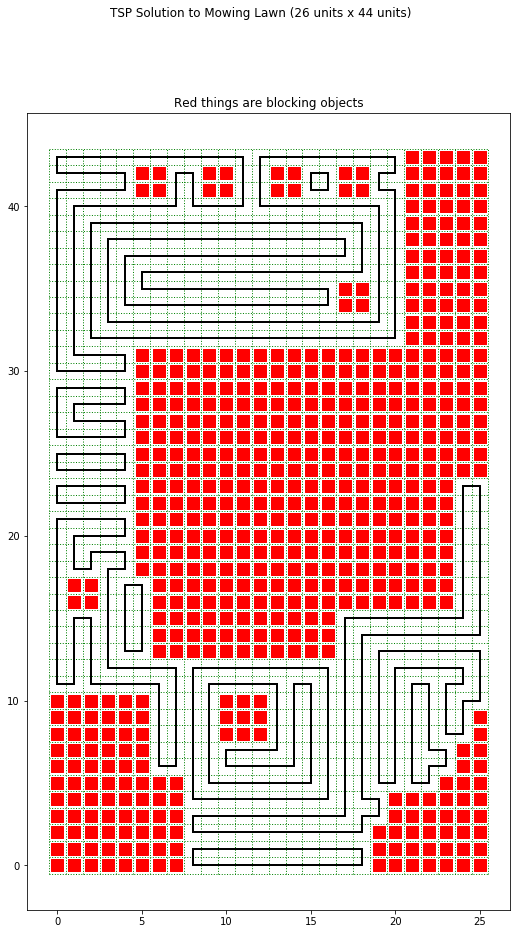

About to find cycles!
Cycle length:  22
Cycle length:  78
Cycle length:  32
Cycle length:  40
Cycle length:  38
Cycle length:  16
Cycle length:  62
Cycle length:  10
Cycle length:  10
Cycle length:  10
Cycle length:  20
Cycle length:  66
Cycle length:  172
Cycle length:  4
Optimize a model with 10552 rows, 5722 columns and 30780 nonzeros
Variable types: 0 continuous, 5722 integer (5722 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]

MIP start did not produce a new incumbent solution
MIP start violates constraint R10538 by 1.000000000

Presolve removed 1762 rows and 400 columns
Presolve time: 0.19s
Presolved: 8790 rows, 5322 columns, 26708 nonzeros
Variable types: 0 continuous, 5322 integer (5322 binary)
Found heuristic solution: objective 190.0000000

Root relaxation: objective 2.300000e+01, 2342 iterations, 0.15 seconds

    Nodes    |    Current Node    |     Objec

     0     0  104.37265    0 1932  182.00000  104.37265  42.7%     -   20s
     0     0  104.74439    0 1940  182.00000  104.74439  42.4%     -   21s
     0     0  104.79117    0 1967  182.00000  104.79117  42.4%     -   21s
     0     0  104.81190    0 1950  182.00000  104.81190  42.4%     -   21s
     0     0  105.19260    0 1979  182.00000  105.19260  42.2%     -   21s
     0     0  105.44989    0 1998  182.00000  105.44989  42.1%     -   21s
     0     0  105.48891    0 2030  182.00000  105.48891  42.0%     -   21s
     0     0  105.49394    0 2027  182.00000  105.49394  42.0%     -   22s
     0     0  105.91556    0 1989  182.00000  105.91556  41.8%     -   22s
     0     0  105.91716    0 2007  182.00000  105.91716  41.8%     -   22s
     0     0  106.06106    0 1976  182.00000  106.06106  41.7%     -   22s
     0     0  106.06106    0 1937  182.00000  106.06106  41.7%     -   23s
     0     2  106.06106    0 1937  182.00000  106.06106  41.7%     -   24s
    64    65  112.22205  

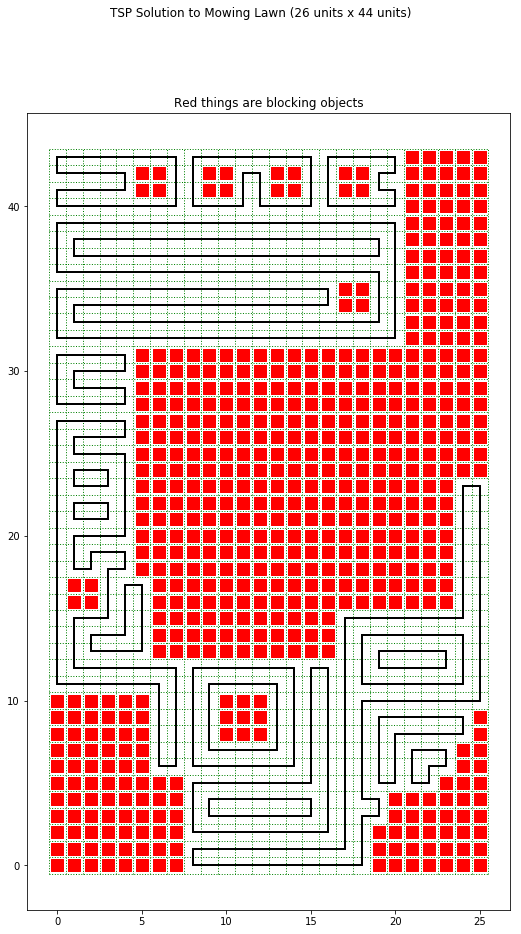

About to find cycles!
Cycle length:  82
Cycle length:  36
Cycle length:  14
Cycle length:  18
Cycle length:  8
Cycle length:  76
Cycle length:  24
Cycle length:  16
Cycle length:  18
Cycle length:  10
Cycle length:  14
Cycle length:  6
Cycle length:  6
Cycle length:  20
Cycle length:  126
Cycle length:  38
Cycle length:  28
Cycle length:  24
Cycle length:  16
Optimize a model with 10571 rows, 5722 columns and 31360 nonzeros
Variable types: 0 continuous, 5722 integer (5722 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]

MIP start did not produce a new incumbent solution
MIP start violates constraint R10552 by 1.000000000

Presolve removed 1762 rows and 400 columns
Presolve time: 0.19s
Presolved: 8809 rows, 5322 columns, 27230 nonzeros
Variable types: 0 continuous, 5322 integer (5322 binary)
Found heuristic solution: objective 190.0000000

Root relaxation: objective 2.

     0     0  100.57576    0 1865  182.00000  100.57576  44.7%     -   17s
     0     0  100.59837    0 1914  182.00000  100.59837  44.7%     -   17s
     0     0  101.03230    0 1857  182.00000  101.03230  44.5%     -   17s
     0     0  101.12520    0 1869  182.00000  101.12520  44.4%     -   17s
     0     0  101.17916    0 1895  182.00000  101.17916  44.4%     -   18s
     0     0  101.18135    0 1888  182.00000  101.18135  44.4%     -   18s
     0     0  101.74847    0 1888  182.00000  101.74847  44.1%     -   18s
H    0     0                     180.0000000  101.74847  43.5%     -   18s
     0     0  101.94996    0 1893  180.00000  101.94996  43.4%     -   18s
     0     0  102.00004    0 1922  180.00000  102.00004  43.3%     -   18s
     0     0  102.00958    0 1907  180.00000  102.00958  43.3%     -   18s
     0     0  102.38764    0 1918  180.00000  102.38764  43.1%     -   19s
     0     0  102.43497    0 1918  180.00000  102.43497  43.1%     -   19s
     0     0  102.48659  

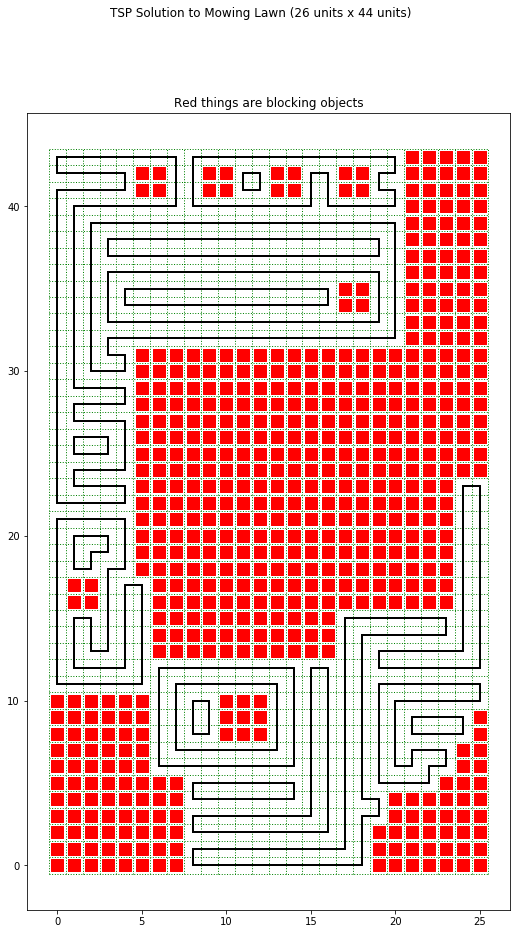

About to find cycles!
Cycle length:  62
Cycle length:  36
Cycle length:  14
Cycle length:  32
Cycle length:  28
Cycle length:  20
Cycle length:  6
Cycle length:  8
Cycle length:  50
Cycle length:  34
Cycle length:  8
Cycle length:  82
Cycle length:  6
Cycle length:  56
Cycle length:  38
Cycle length:  26
Cycle length:  34
Cycle length:  36
Cycle length:  4
Optimize a model with 10590 rows, 5722 columns and 31940 nonzeros
Variable types: 0 continuous, 5722 integer (5722 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]

MIP start did not produce a new incumbent solution
MIP start violates constraint R10571 by 1.000000000

Presolve removed 1747 rows and 393 columns
Presolve time: 0.19s
Presolved: 8843 rows, 5329 columns, 27791 nonzeros
Variable types: 0 continuous, 5329 integer (5329 binary)
Found heuristic solution: objective 190.0000000

Root relaxation: objective 2.300

     0     0   98.36646    0 1907  180.00000   98.36646  45.4%     -   16s
     0     0   98.54629    0 1943  180.00000   98.54629  45.3%     -   17s
     0     0   98.57605    0 1944  180.00000   98.57605  45.2%     -   17s
     0     0   98.57932    0 1950  180.00000   98.57932  45.2%     -   17s
     0     0   98.81069    0 1903  180.00000   98.81069  45.1%     -   17s
     0     0   98.92739    0 1938  180.00000   98.92739  45.0%     -   17s
     0     0   98.95922    0 1958  180.00000   98.95922  45.0%     -   17s
     0     0   98.98171    0 1974  180.00000   98.98171  45.0%     -   17s
     0     0   99.33430    0 1969  180.00000   99.33430  44.8%     -   18s
     0     0   99.44724    0 1978  180.00000   99.44724  44.8%     -   18s
     0     0   99.47243    0 2001  180.00000   99.47243  44.7%     -   18s
     0     0   99.60433    0 1934  180.00000   99.60433  44.7%     -   18s
     0     0   99.60433    0 1912  180.00000   99.60433  44.7%     -   18s
     0     2   99.60433  

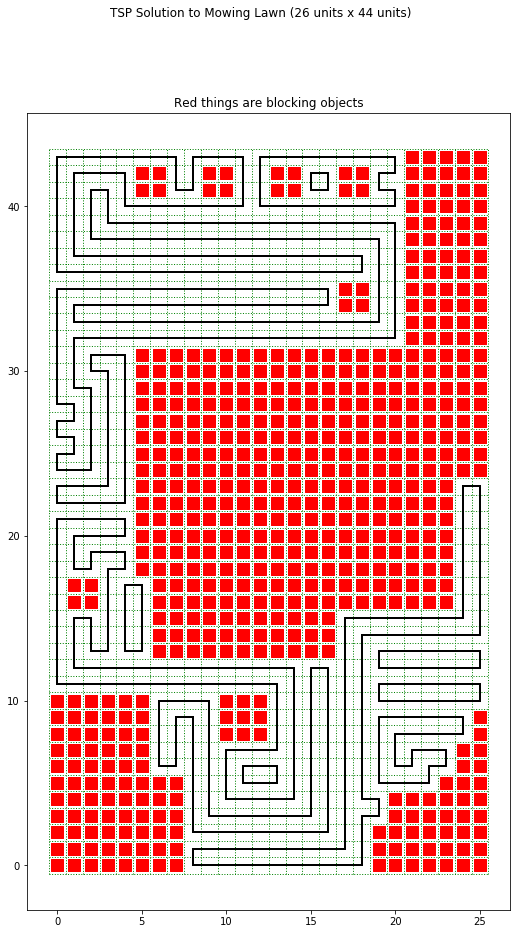

About to find cycles!
Cycle length:  82
Cycle length:  60
Cycle length:  86
Cycle length:  6
Cycle length:  26
Cycle length:  14
Cycle length:  14
Cycle length:  10
Cycle length:  28
Cycle length:  148
Cycle length:  78
Cycle length:  24
Cycle length:  4
Optimize a model with 10603 rows, 5722 columns and 32520 nonzeros
Variable types: 0 continuous, 5722 integer (5722 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]

MIP start did not produce a new incumbent solution
MIP start violates constraint R10590 by 1.000000000

Presolve removed 1762 rows and 400 columns
Presolve time: 0.21s
Presolved: 8841 rows, 5322 columns, 28275 nonzeros
Variable types: 0 continuous, 5322 integer (5322 binary)
Found heuristic solution: objective 190.0000000

Root relaxation: objective 2.300000e+01, 2482 iterations, 0.23 seconds

    Nodes    |    Current Node    |     Objective Bounds      | 

In [ ]:
m.optimize()
plot_tsp_solution(flat_tiles, location_edges, row_count=len(tiles), col_count=len(tiles[0]))

while True:
    shortest_cycle, cycle_count, cycles = find_cycles(location_edges)
    if cycle_count <= 2:
        print('Solved!')
        plot_tsp_solution(flat_tiles, location_edges, row_count=len(tiles), col_count=len(tiles[0]))
        break
    else:
        for cycle in cycles:
            m.addConstr(sum([location_edges[to_loc(edge)] for edge in cycle]) <= len(cycle)-1)
        m.optimize()
        plot_tsp_solution(flat_tiles, location_edges, row_count=len(tiles), col_count=len(tiles[0]))

In [ ]:
plot_tsp_solution(flat_tiles, location_edges, row_count=len(tiles), col_count=len(tiles[0]))